In [0]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as scp
import random as rd
import timeit
import itertools
import copy
import collections
import scipy.signal
plt.style.use('ggplot')

# PROJECT: SIMULATION OF RELATEDNESS SPECTRA USING NETWORK CONVOLUTION ON RANDOMLY GENERATED PEDIGREES



*   1. Radomly generate parent-child matrices
*   2. Carry out implementation of cousin marriage numbers
*   3. Carry out network convolution
*   4. Carry out steps 1-3 but for the X chromosome
*   5. Carry out steps 1-3 but for uniparental subpopulations



## FUNCTIONS



In [0]:
def simulate_auto(N = 100, generations = 500, init = "uniform", init_relatedness = 0.00001, 
                  skew = "uniform", skew_param = {0:0.15,1:0.73,2:0.10,3:0.02}, 
                  fitness = "uniform", fitness_param = 0,
                  inbreeding_vec = [0.03, 0.03, 0.03, 0.03]):
  
  
  #1. First generate a base relatedness matrix for the first generation
  G0 = produce_G0(N, init, init_relatedness)
  # Generate G_seq and actual inbreeding values to store values of G and inbreeding percentages for all generations
  G_seq = [G0]
  actual_inbreeding = []
  M_seq = []
  
  
  #2. Then generate parent_child_matrices and multiply for the number of generations specified
  # in the first generation, there is no sibling matrix. The sibling matrix is useful for rewiring later
  # In the first generation, there is also no parent-child matrix.
  G = G0
  Sib_Matrix = None
  Sib_Matrix_prev = None
  M = None
  
  
  for i in np.arange(generations):
    #Store the previous matrix
    G_prev = G
    Sib_Matrix_prev_prev = Sib_Matrix_prev
    Sib_Matrix_prev = Sib_Matrix
    
    M_prev = M
    M, Sib_Matrix, actual_inbreeding_values = parent_child_matrix(N, i, Sib_Matrix_prev_prev, M_prev, skew, skew_param, fitness, fitness_param, inbreeding_vec)
    actual_inbreeding.append(copy.copy(actual_inbreeding_values))
    M_seq.append(copy.copy(M))
    
    
    
    """print(M)
    print(Sib_Matrix)
    fig = plt.figure()
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    ax1.set_title("parent-child")
    ax2.set_title("Sib_matrix")
    ax3.set_title("current_G")
    ax4.set_title("previous_G")
    ax1.imshow(M, cmap='hot')
    ax2.imshow(Sib_Matrix, cmap='hot')"""


    # Perform the matrix multiplication, equivalent to the below, using scipy sparse matrices,
    # and convert back to dense matrices for efficient indexing and arithmetic
    # G = 0.25*np.matmul(np.matmul(M , G), M.transpose())
    G = scp.sparse.csr_matrix(G)
    M = scp.sparse.csr_matrix(M)
    G = 0.25*(scp.sparse.csr_matrix.dot(scp.sparse.csr_matrix.dot(M, G), M.transpose()))
    G = G.toarray()
    M = M.toarray()
    #Reset the diagonal of the matrix to account for self-relationships
    for index in np.arange(N):
      index_parents = np.where(M[index,] == 1)
      index_father = index_parents[0][0]
      index_mother = index_parents[0][1]
      #G[index, index] = G[index, index] - 0.25*(G_prev[index_father, index_father] + G_prev[index_mother, index_mother]) + 0.5
      G[index, index] = 0.5*(G_prev[index_father, index_mother]) + 0.5
    G_seq.append(G)
    
    
    
    

    """ax3.imshow(G, cmap='hot')
    ax4.imshow(G_prev, cmap='hot')
    plt.show()
    print(i)"""

    
  return G, G_seq, M_seq, actual_inbreeding






# 3. Now using M_seq, generate the uniparentals of the last generation.
  
def get_final_uniparentals(M_seq, num_clades = (10, 10)):
  N = M_seq[0].shape[0]
  init_uniparental_Y = generate_uniparental_vector(N, num_clades[0], unitype = "Y")
  init_uniparental_mtDNA = generate_uniparental_vector(N, num_clades[1], unitype = "mtDNA")
  result_Y = transmit(M_seq, init_uniparental_Y, unitype="Y")
  result_mtDNA = transmit(M_seq, init_uniparental_mtDNA, unitype="mtDNA")
  return result_Y, result_mtDNA


## Part 1
### a. `produce_G0()`
Generate a base relatedness matrix, of either uniform, normal or zero type.  
Uniform: uniform rate of low relatedness in population.  
Normal: low, normally distributed rate of relatedness.  
Zero: Zero relatedness

In [0]:
# First generate a base relatedness matrix
""" 
Parameters:
N: Population size
init: Pattern of Initial relatedness between persons. zero, normal, and uniform options.
init_relatedness: Mean and sd of relatedness if normal, value of relatedness if uniform, not used if zero
"""
def produce_G0(N = 100, init = "uniform", init_relatedness = 0.00001):
  if init == "uniform":
    result = np.full((N, N), init_relatedness)
    result = result + 0.5*(np.identity(N))
  if init == "normal":
    result = np.random.normal(init_relatedness, init_relatedness, (N, N))
    result = result.clip(min=0)
    result = result + 0.5*(np.identity(N))
  if init == "zero":
    result = np.zeros((N, N))
    result = result + 0.5*(np.identity(N))
  
  return result

## Part 2
Generate random parent-child matrices
### a. `parent_child_matrix()`
Generate parent-child matrices.  
Start with zero matrices, add a vector of marriages, and populate the matrix with children of the marriages.  

### b. `Rewire()`
Rewire the parent-child matrices to accomodate cousin marriages using the Parent-sibling matrix



In [0]:
""" 
Parameters:
N: Population size
skew: reproductive skew. Parameter given by skew_param. 
fitness: fitness inequality. Parameter given by fitness_param
inbreeding_vec: vecotr of rates of each type of cousin marriage (FBD, FZD, MBD, MZD)

Returns a matrix of parent-child relations. Child_index on rows, Parent_index on columns.
First half of indices of parent-child matrix are always male, second half always female.
First a marriage vector is generated, depending on the type of reproductive skew.
Then the marriages are used to populate the parent-child-matrix, using the fitness inequality.

"""
def parent_child_matrix(N, i, Parent_Sib_Matrix, M_prev,
                        skew = "uniform", skew_param = {0:0.15,1:0.73,2:0.10,3:0.02},
                        fitness = "uniform", fitness_param = 0,
                        inbreeding_vec = [0.01, 0.01, 0.01, 0.01]):
  # Start with an empty matrix
  result = np.zeros((N,N))
  Sib_Matrix = np.zeros((N,N))
  actual_inbreeding_values = []
  
  # Generate the marriage pairing, kept in a dictionary.
  # First generate ranges of values for the keys of the parents.
  father_ids = np.arange(N/2)
  mother_ids = np.arange(N/2,N)
  marriage_dict = {}
  # If mating is uniform, Pair them up, uniformly and monogamously.
  if skew == "uniform":
    for father_id in father_ids:
      mother_id = rd.choice(mother_ids)
      mother_ids = np.delete(mother_ids, np.where(mother_ids == mother_id))
      marriage_dict[father_id] = mother_id
  # Pair them up in a skewed way, taking into account the reproductive skew parameter, if skewed.
  
  
  # Rewire the parent-child matrix with the cousin marriage percentages using the cousin marriage vector
  if Parent_Sib_Matrix is not None and sum(inbreeding_vec) > 0:
    marriage_dict, actual_inbreeding_values = Rewire(N, marriage_dict, Parent_Sib_Matrix, M_prev, inbreeding_vec)
  else: 
    actual_inbreeding_values = [0,0,0,0]
  
  # Populate the parent-child matrix with parent-child relationships using the marriage pairings
  # If the fitness parameter is uniform, populate the parent-child matrix with two children per parent
  # If the child row is already filled, add it to a list, so every child only has two parents (no repeat selection).
  # Then add the pair of children to the sibling matrix
  child_ids = np.arange(N)
  if fitness == "uniform":
    for father_id,mother_id in marriage_dict.iteritems():
      child_ids_sib_pair = [0,0]
      for i in range(2):
        child_id = rd.choice(child_ids)
        child_ids = np.delete(child_ids, np.where(child_ids == child_id))
        result[child_id, father_id] = 1
        result[child_id, mother_id] = 1
        child_ids_sib_pair[i] = child_id
      
      Sib_Matrix[child_ids_sib_pair[0],child_ids_sib_pair[1]] = 1
      Sib_Matrix[child_ids_sib_pair[1],child_ids_sib_pair[0]] = 1 
  
  return result, Sib_Matrix, actual_inbreeding_values




""" 
Parameters:
marriage_dict:     marriage dictionary of the current generation
M_prev:            parent-child matrix of the current and the previous generation
Parent_Sib_Matrix: parent sibling matrix of the previous generation. Records sibling pairs
                   among people in the parental generation.
inbreeding_vec:    proportion of each inbreeding type.

Returns a rewired set of marriages taking into account cousin marriages.
"""
def Rewire(N, marriage_dict, Parent_Sib_Matrix, M_prev, inbreeding_vec):
  
  actual_inbreeding_values = inbreeding_vec
  marriage_dict = marriage_dict
  #print("Original:", marriage_dict) ###
  
  # first convert nonzero elements of the Parent-sibling matrix into a list of Sib pairs
  # Then divide the list by gender of the sibling pairs
  # To prevent double counting, delete one of an identical pair of MF-FM tuples
  # For Parent_BroSis, the brother always comes first in the pair
  N = len(Parent_Sib_Matrix)
  All_Siblings = [(val1,val2) for val1, val2 in itertools.izip(*np.nonzero(Parent_Sib_Matrix))]
  for combo in itertools.combinations(All_Siblings, 2):
    if combo[0][0] == combo[1][1]:
      All_Siblings.remove(combo[0])
  
  Parent_Brothers = [pair for pair in All_Siblings if pair[0]<N/2 and pair[1]<N/2]
  #print("Parent_Brothers: ", Parent_Brothers) ###
  Parent_Sisters = [pair for pair in All_Siblings if pair[0]>N/2 and pair[1]>N/2]
  Parent_BroSis = [pair for pair in All_Siblings if pair not in Parent_Brothers and pair not in Parent_Sisters]
  
  
  # Now create a dictionary of possible cousins to marry, using M_prev child indices (rows)
  # For each pair in the sibling list, create a set of children of that sibling. End up with list
  # of children of each sibling in the sibling pair.
  # Create all possible marriages through cartesian product of two lists, and filter for gender
  possible_FBD_cousin_marriage_pairs = []
  possible_MZD_cousin_marriage_pairs = []
  possible_FZD_cousin_marriage_pairs = []
  possible_MBD_cousin_marriage_pairs = []
  
  for pair in Parent_Brothers:
    brother0_children = [child for child in np.where(M_prev[:,pair[0]] == 1)[0]]
    brother1_children = [child for child in np.where(M_prev[:,pair[1]] == 1)[0]]    
    #print("first bro child: ", brother0_children) ###
    #print("second bro child: ", brother1_children) ###
    possible_FBD_cousin_pairs = list(itertools.product(brother0_children, brother1_children))
    possible_FBD_cousin_pairs = [pair for pair in possible_FBD_cousin_pairs if (pair[0]<N/2 and pair[1]>N/2) or (pair[0]>N/2 and pair[1]<N/2)]
    possible_FBD_cousin_marriage_pairs.extend(possible_FBD_cousin_pairs)
  
  for pair in Parent_Sisters:
    sister0_children = [child for child in np.where(M_prev[:,pair[0]] == 1)[0]]
    sister1_children = [child for child in np.where(M_prev[:,pair[1]] == 1)[0]]
    possible_MZD_cousin_pairs = list(itertools.product(sister0_children, sister1_children))
    possible_MZD_cousin_pairs = [pair for pair in possible_MZD_cousin_pairs if (pair[0]<N/2 and pair[1]>N/2) or (pair[0]>N/2 and pair[1]<N/2)]
    possible_MZD_cousin_marriage_pairs.extend(possible_MZD_cousin_pairs)
  
  # For FZD marriage, the filtering step requires that the child of the brother is male and the
  # Child of the sister is female
  for pair in Parent_BroSis:
    brother0_children = [child for child in np.where(M_prev[:,pair[0]] == 1)[0]]
    sister1_children = [child for child in np.where(M_prev[:,pair[1]] == 1)[0]]
    possible_cross_cousin_pairs = list(itertools.product(brother0_children, sister1_children))
    possible_FZD_cousin_pairs = [pair for pair in possible_cross_cousin_pairs if (pair[0]<(N/2) and pair[1]>(N/2))]
    possible_FZD_cousin_marriage_pairs.extend(possible_FZD_cousin_pairs)
    # For MBD marriage, the filtering step requires that the child of the brother is female and the
    # Child of the sister is male
    possible_MBD_cousin_pairs = [pair for pair in possible_cross_cousin_pairs if (pair[0]>(N/2) and pair[1]<(N/2))]
    possible_MBD_cousin_marriage_pairs.extend(possible_MBD_cousin_pairs)

    
  """
  print(len(possible_FBD_cousin_marriage_pairs))
  print(len(possible_MZD_cousin_marriage_pairs))
  print(len(possible_FZD_cousin_marriage_pairs))
  print(len(possible_MBD_cousin_marriage_pairs))
  print("-")
  """

  # Proceed with rewiring
  # For each sibling pair, test if they have a son and daughter in the right config.
  # If not already married, marry them into cousin marriages, and increment the set of cousin marriages.
  # The marriage partners that are broken are rewired into their own marriages.
  # If already married, but not in the set, add to set. If set size tells us the right rate
  # of cousin marriages is reached, end the process.
  
  # First do for FBD
  FBD_count = 0
  for pair in possible_FBD_cousin_marriage_pairs:
    FBD_pair = (sorted(list(pair)))
    if marriage_dict[FBD_pair[0]] == FBD_pair[1]:
      possible_FBD_cousin_marriage_pairs.remove(pair)
      FBD_count += 1
      #print("FBD_COUNT: ", FBD_count) ###
  while(float(FBD_count)/len(marriage_dict) < inbreeding_vec[0]):
    if len(possible_FBD_cousin_marriage_pairs) != 0:
      pair = rd.choice(possible_FBD_cousin_marriage_pairs)
      possible_FBD_cousin_marriage_pairs.remove(pair)
      FBD_pair = (sorted(list(pair)))
      current_marriage_female = marriage_dict[FBD_pair[0]]
      current_marriage_male = marriage_dict.keys()[marriage_dict.values().index(FBD_pair[1])]
      del marriage_dict[FBD_pair[0]]
      marriage_dict[FBD_pair[0]] = FBD_pair[1]
      marriage_dict[current_marriage_male] = current_marriage_female
      FBD_count += 1
      #print("FBD_COUNT: ", FBD_count) ###
      #print(FBD_pair) ###
      #print("Rewired:", marriage_dict) ###
    else:
      break
  # print(float(FBD_count)) ###
  actual_inbreeding_values[0] = float(FBD_count)/len(marriage_dict)
    
  # Now do for MZD
  MZD_count = 0
  for pair in possible_MZD_cousin_marriage_pairs:
    MZD_pair = (sorted(list(pair)))
    if marriage_dict[MZD_pair[0]] == MZD_pair[1]:
      possible_MZD_cousin_marriage_pairs.remove(pair)
      MZD_count += 1
      #print("MZD_COUNT: ", MZD_count) ###
  while(float(MZD_count)/len(marriage_dict) < inbreeding_vec[1]):
    if len(possible_MZD_cousin_marriage_pairs) != 0:
      pair = rd.choice(possible_MZD_cousin_marriage_pairs)
      possible_MZD_cousin_marriage_pairs.remove(pair)
      MZD_pair = (sorted(list(pair)))
      current_marriage_female = marriage_dict[MZD_pair[0]]
      current_marriage_male = marriage_dict.keys()[marriage_dict.values().index(MZD_pair[1])]
      del marriage_dict[MZD_pair[0]]
      marriage_dict[MZD_pair[0]] = MZD_pair[1]
      marriage_dict[current_marriage_male] = current_marriage_female
      MZD_count += 1
      #print("MZD_COUNT: ", MZD_count) ###
      #print(MZD_pair) ###
      #print("Rewired:", marriage_dict) ###
    else:
      break
  actual_inbreeding_values[1] = float(MZD_count)/len(marriage_dict)
  
  # Now do for FZD
  FZD_count = 0
  for pair in possible_FZD_cousin_marriage_pairs:
    FZD_pair = (sorted(list(pair)))
    if marriage_dict[FZD_pair[0]] == FZD_pair[1]:
      possible_FZD_cousin_marriage_pairs.remove(pair)
      FZD_count += 1
      #print("FZD_COUNT: ", FZD_count) ###
  while(float(FZD_count)/len(marriage_dict) < inbreeding_vec[2]):
    if len(possible_FZD_cousin_marriage_pairs) != 0:
      pair = rd.choice(possible_FZD_cousin_marriage_pairs)
      possible_FZD_cousin_marriage_pairs.remove(pair)
      FZD_pair = (sorted(list(pair)))
      current_marriage_female = marriage_dict[FZD_pair[0]]
      current_marriage_male = marriage_dict.keys()[marriage_dict.values().index(FZD_pair[1])]
      del marriage_dict[FZD_pair[0]]
      marriage_dict[FZD_pair[0]] = FZD_pair[1]
      marriage_dict[current_marriage_male] = current_marriage_female
      FZD_count += 1
      #print("FZD_COUNT: ", FZD_count) ###
      #print(FZD_pair) ###
      #print("Rewired:", marriage_dict) ###
    else:
      break
  actual_inbreeding_values[2] = float(FZD_count)/len(marriage_dict)
  
  # Now do for MBD
  MBD_count = 0
  for pair in possible_MBD_cousin_marriage_pairs:
    MBD_pair = (sorted(list(pair)))
    if marriage_dict[MBD_pair[0]] == MBD_pair[1]:
      possible_MBD_cousin_marriage_pairs.remove(pair)
      MBD_count += 1
      #print("MBD_COUNT: ", MBD_count) ###
  while(float(MBD_count)/len(marriage_dict) < inbreeding_vec[3]):
    if len(possible_MBD_cousin_marriage_pairs) != 0:
      pair = rd.choice(possible_MBD_cousin_marriage_pairs)
      possible_MBD_cousin_marriage_pairs.remove(pair)
      MBD_pair = (sorted(list(pair)))
      current_marriage_female = marriage_dict[MBD_pair[0]]
      current_marriage_male = marriage_dict.keys()[marriage_dict.values().index(MBD_pair[1])]
      del marriage_dict[MBD_pair[0]]
      marriage_dict[MBD_pair[0]] = MBD_pair[1]
      marriage_dict[current_marriage_male] = current_marriage_female
      MBD_count += 1
      #print("MBD_COUNT: ", MBD_count) ###
      #print(MBD_pair) ###
      #print("Rewired:", marriage_dict) ###
    else:
      break
  actual_inbreeding_values[3] = float(MBD_count)/len(marriage_dict)

  
  #print("Rewired_final:", marriage_dict) ###
  #print("actual_inbreeding_values: ", actual_inbreeding_values) ###
  return marriage_dict, actual_inbreeding_values

## Part 3
Generate uniparental inheritance matrices given a chain of parent-child matrices.
Calculate the uniparental relatedness versus the total relatedness
### a. `generate_uniparental_vector()`
Generate a random vector of uniparental markers

### b. `transmit_y()`
Transmits the uniparental markers passed in along the implicit pedigree using the chain of M_seq() along males

### c. `transmit_mtDNA()`
Transmits the uniparental markers passed in along the implicit pedigree using the chain of M_seq() along females

### c. `calc_uniparental_rel()`
Calculates the average relatedness among uniparental subpopulations.


In [0]:
""" 
Parameters:
M_seq:      Implicit pedigree represented by parent-child matrices
num_clades: Number of clades of Y-chromosomes and mtDNA to be used in the simulation
"""
def generate_uniparental_vector(N, num_clades, unitype):
  result = []
  if unitype == "Y":
    n_of_each_type = (N/2)//num_clades
    for n in range(num_clades):
      result.extend([n+1]*n_of_each_type)
    result.extend([0]*(N - len(result)))  
  if unitype == "mtDNA":
    result.extend([0]*(N/2))
    n_of_each_type = (N/2)//num_clades
    for n in range(num_clades):
      result.extend([n+1]*n_of_each_type)
         
  # print(result) 
  return result

""" 
Parameters:
M_seq:      Implicit pedigree represented by parent-child matrices
num_clades: Number of clades of Y-chromosomes and mtDNA to be used in the simulatiojn
"""
def transmit(M_seq, init_uniparental_vec, unitype):
  result_uniparental = init_uniparental_vec
  N = len(result_uniparental)
  if unitype == "Y":
    for M in M_seq:
      # print("First Y", result_uniparental) ###
      result_uniparental = np.matmul(M, result_uniparental)
      result_uniparental = [n if index < float(N)/2 else 0 for index, n in enumerate(result_uniparental) ]
      # print("Now_Y", result_uniparental) ###
  if unitype == "mtDNA":
    for M in M_seq:
      # print("First mtDNA", result_uniparental) ###
      result_uniparental = np.matmul(M, result_uniparental)
      result_uniparental = [n if index >= float(N)/2 else 0 for index, n in enumerate(result_uniparental) ]
      # print("Now mtDNA", result_uniparental) ###
  
  return result_uniparental



""" 
Parameters:
Spectra_kinship:      Final matrix of kinship coefficients
final_uniparental:    Vector of uniparental identities
"""
def calc_rel_uniparental(spectra_kinship, final_uniparental_Y, final_uniparental_mtDNA):
  random_rel = np.mean(list(spectra_kinship[np.triu_indices(spectra_kinship.shape[0])]))
  
  Y_clade_dict = collections.defaultdict(list)
  for clade in list(set([int(i) for i in final_uniparental_Y])):
    IDs = [index for index,x in enumerate(final_uniparental_Y) if x==clade]
    for ID in IDs:
      Y_clade_dict[clade].append(ID)
  # print("Y_Dict", Y_clade_dict) ###
  
  mtDNA_clade_dict = collections.defaultdict(list)
  for clade in list(set([int(i) for i in final_uniparental_mtDNA])):
    IDs = [index for index,x in enumerate(final_uniparental_mtDNA) if x==clade]
    for ID in IDs:
      mtDNA_clade_dict[clade].append(ID)
  # print("mtDNA_Dict", mtDNA_clade_dict) ###
  
  
  Y_rel = []
  for ID in Y_clade_dict:
    if ID != 0:
      combinations_ID = itertools.combinations(Y_clade_dict[ID],2)
      for combo in combinations_ID:
        if combo[0] != combo[1]:
          Y_rel.append(spectra_kinship[combo[0], combo[1]])
  Y_rel = np.mean(Y_rel)
  
  mtDNA_rel = []
  for ID in mtDNA_clade_dict:
    if ID != 0:
      combinations_ID = itertools.combinations(mtDNA_clade_dict[ID],2)
      for combo in combinations_ID:
        if combo[0] != combo[1]:
          mtDNA_rel.append(spectra_kinship[combo[0], combo[1]])
  mtDNA_rel = np.mean(mtDNA_rel)
  
  return random_rel, Y_rel, mtDNA_rel

# CODED PROGRAM

('Time: ', 0.6482229232788086)


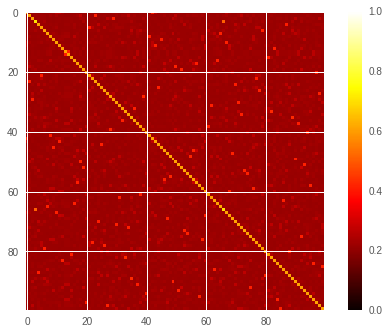

('Inbreeding Coefficient', 0.22171318831097778)
('Actual Inbreeding Vectors: ', [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0,

In [0]:

start = timeit.default_timer()
# rd.seed(111)
spectra_kinship, G_seq, M_seq, actual_inbreeding_values = simulate_auto(N = 100, generations = 10, init = "uniform", init_relatedness = 0, inbreeding_vec = [0,0,0,0])
stop = timeit.default_timer()
print('Time: ', stop - start) 


plt.imshow(spectra_kinship, cmap='hot')
plt.colorbar()
plt.clim(0,1)
plt.show()

Fxx = np.diagonal(spectra_kinship)
print("Inbreeding Coefficient", np.mean((Fxx*2)-1))
print("Actual Inbreeding Vectors: ", actual_inbreeding_values)
# print(G_seq)

final_uniparental_Y, final_uniparental_mtDNA = get_final_uniparentals(M_seq, num_clades = (50, 50))
print("Final Y-chromosomes are", final_uniparental_Y)
print("Final mtDNA are", final_uniparental_mtDNA)
random_rel, Y_rel, mtDNA_rel = calc_rel_uniparental(spectra_kinship, final_uniparental_Y, final_uniparental_mtDNA)
print(random_rel, Y_rel, mtDNA_rel)

# GRAPHING AND PLOTTING

In [0]:
# Show behaviour of Y/mt and Y/rand for 50 runs

def gen_FBD ():
  
  Y_mt = []
  Y_rand = []
  for i in np.linspace(0, 0.5, 50):
    inbreeding_vec = [0,i,0,0]
    spectra_kinship, G_seq, M_seq, actual_inbreeding_values = simulate_auto(N = 500, generations = 10, init = "uniform", init_relatedness = 0, inbreeding_vec = inbreeding_vec)
    actual_inbreeding_values = np.array(actual_inbreeding_values)
    final_uniparental_Y, final_uniparental_mtDNA = get_final_uniparentals(M_seq, num_clades = (50, 50))
    random_rel, Y_rel, mtDNA_rel = calc_rel_uniparental(spectra_kinship, final_uniparental_Y, final_uniparental_mtDNA)
    
    Y_mt.append(mtDNA_rel/Y_rel)
    Y_rand.append(mtDNA_rel/random_rel)
  
  return Y_mt, Y_rand

Y_mt_list = []
S = []
Y_rand_list = []
for i in range(5):
  Y_mt, Y_rand = gen_FBD()
  Y_mt_list.append(copy.copy(Y_mt))
  Y_rand_list.append(copy.copy(Y_rand))
  S.append(np.linspace(0, 0.5, 50))


[[1.018326587264962, 1.0799775272383083, 1.1365970752911099, 1.1385546918012324, 1.0656156216076735, 1.0230370048866788, 0.9322292071430202, 0.9073896020095835, 1.1181793458565732, 0.9693102270757653, 1.261034982178952, 1.0598163238586802, 1.1564531430917468, 1.0456787938561138, 1.1569736684351777, 1.0656893686450981, 0.8705430508884953, 0.9592808730702764, 1.0384536332750836, 0.9267895300841703, 1.2893249238535287, 1.2721817930728523, 1.3863949803287343, 1.148566578607962, 1.2011936066932263, 0.8396871019572387, 1.143152672878374, 0.8976895762819715, 1.1207376865488068, 1.0658787531089007, 1.0611173606564885, 1.0177083057151795, 0.8449218044707202, 0.9654054439162503, 1.348869159626797, 1.1368323904093227, 0.9931950624090574, 1.1191081214851935, 1.0219087059052063, 1.3855736535958658, 1.0774195816584557, 1.1289089458294788, 1.6118350213297752, 1.4113691262612242, 0.9340516952509376, 1.4162843634441442, 1.1039916348899341, 1.3089779407942563, 0.9866297817901181, 0.985932922975484], [1.

Text(0,0.5,u'Fraction')

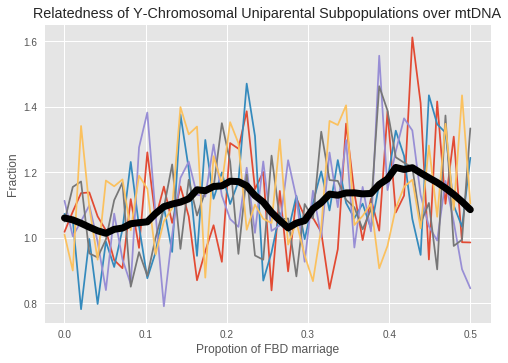

In [0]:
print(Y_mt_list)
plt.plot(np.linspace(0, 0.5, 50), Y_mt_list[0])
plt.plot(np.linspace(0, 0.5, 50), Y_mt_list[1])
plt.plot(np.linspace(0, 0.5, 50), Y_mt_list[2])
plt.plot(np.linspace(0, 0.5, 50), Y_mt_list[3])
plt.plot(np.linspace(0, 0.5, 50), Y_mt_list[4])
Y_mean = np.mean(np.array(Y_mt_list), axis = 0)
yhat = scp.signal.savgol_filter(Y_mean, 11, 3)

plt.plot(np.linspace(0, 0.5, 50), yhat, color = "black", linewidth=7.0)
plt.title("Relatedness of Y-Chromosomal Uniparental Subpopulations over mtDNA")
plt.xlabel("Propotion of FBD marriage")
plt.ylabel("Fraction")


[[1.117612034946985, 1.0385284922548825, 0.8680398199668302, 0.7216872795408825, 1.0140152562242255, 0.8677933976067256, 1.1721376309978342, 1.0759094394351538, 1.4312129918170147, 1.0744502214282738, 1.089757565593897, 1.5063727767530768, 1.1124188486060804, 0.9068950376346129, 0.9125719521129629, 1.176208366453565, 1.1942277525285905, 1.1616240146870107, 1.1604754242386104, 0.9452188475320233, 1.0755808981203576, 1.0134043175690892, 1.3451954185682413, 1.6428047494653786, 0.9977545671408702, 1.2483957802165944, 1.333137691358144, 1.311641888352106, 1.2470235091212738, 1.1717543829152175, 1.2182802170059872, 1.2254335316283216, 1.3630841471042021, 1.110237713925958, 1.0658442054087962, 1.05739693739933, 1.0276724330697455, 1.313577068663704, 1.074233161109555, 1.001190773621776, 1.1343837262547467, 1.2359483274010816, 1.1254810783574072, 1.7304060524029758, 1.493629302375277, 1.0354497146001251, 1.455391248114027, 1.1770758810742665, 1.1185487037065587, 1.149829536832141], [0.87280402

Text(0,0.5,u'Fraction')

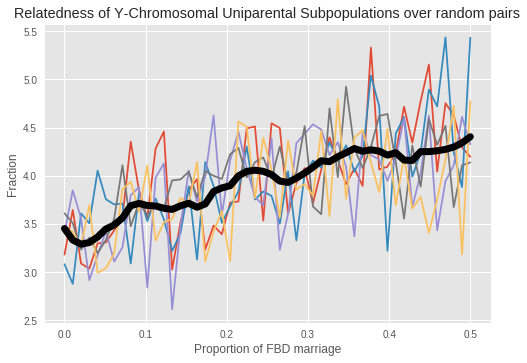

In [0]:
print(Y_mt_list)
plt.plot(np.linspace(0, 0.5, 50), Y_rand_list[0])
plt.plot(np.linspace(0, 0.5, 50), Y_rand_list[1])
plt.plot(np.linspace(0, 0.5, 50), Y_rand_list[2])
plt.plot(np.linspace(0, 0.5, 50), Y_rand_list[3])
plt.plot(np.linspace(0, 0.5, 50), Y_rand_list[4])
Y_mean = np.mean(np.array(Y_rand_list), axis = 0)
yhat = scp.signal.savgol_filter(Y_mean, 11, 3)

plt.plot(np.linspace(0, 0.5, 50), yhat, color = "black", linewidth=7.0)
plt.title("Relatedness of Y-Chromosomal Uniparental Subpopulations over random pairs")
plt.xlabel("Proportion of FBD marriage")
plt.ylabel("Fraction")